In [1]:
import h5py
import numpy as np
from utils import (SeismicParameters, evaluate_ratio,
                   ratio_gmm_pgv, ratio_gmm_pga)
from pyproj import Geod
from openquake.hazardlib.contexts import RuptureContext, DistancesContext, SitesContext
from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014
from openquake.hazardlib.gsim.kanno_2006 import Kanno2006Shallow, Kanno2006Deep
from openquake.hazardlib import imt, const
from einops import rearrange
from utils import (SeismicParameters, evaluate_ratio, calculate_distance_binned_ratios,
                   print_dataset_summary, moving_average_envelope_adaptive, fft)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import genpareto
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})


In [2]:
geod = Geod(ellps="WGS84")

def epicentral_distance(lat_src, lon_src, lat_sta, lon_sta):
    """Great‑circle surface distance [km]."""
    _, _, dist_m = geod.inv(lon_src, lat_src, lon_sta, lat_sta)
    return dist_m / 1_000.0

def point_source_distances(lat_src, lon_src, depth_km,
                           lat_sta, lon_sta):
    """
    Return (R_epi, R_hyp, R_rup, R_jb) for a point source.
    
    For point sources:
    - R_epi: epicentral distance
    - R_hyp: hypocentral distance  
    - R_rup: closest distance to rupture (= R_hyp for point sources)
    - R_jb: Joyner-Boore distance (= R_epi for point sources)
    """
    R_epi = epicentral_distance(lat_src, lon_src, lat_sta, lon_sta)
    R_hyp = np.sqrt(R_epi**2 + depth_km**2)        # hypocentral
    R_rup = R_hyp                                   # point‑source ≈ rupture
    R_jb  = R_epi                                   # CORRECTED: R_jb = R_epi for point sources
    return R_epi, R_hyp, R_rup, R_jb

# Optional: EPRI‑2003 adjustment from R_epi → R_jb (for finite fault approximation)
# Use this only if you want to approximate finite fault effects for point sources
def epri_epicentral_to_rjb(repi, mag,
                           C1=-2.118, C2=0.17, C3=-0.14, C4=1.19, C5=0.09):
    """
    EPRI-2003 empirical adjustment from epicentral to Joyner-Boore distance.
    Use with caution - coefficients are frequency/IM dependent.
    """
    h = np.exp(C4 + C5 * (mag - 6))
    rprime = np.sqrt(repi**2 + h**2)
    return repi * (1 - 1 / np.cosh(C1 + C2 * (mag - 6) + C3 * np.log(rprime)))

def build_kanno_contexts_one(mag, depth_km, rhyp, vs30, vs30_measured=True):
    """
    Returns sites, rupture, distances for ONE site–source pair
    compatible with Kanno et al. (2006).

    Parameters
    ----------
    mag : float          # Moment magnitude
    depth_km : float     # Focal depth (km)
    rrup : float         # Closest distance to rupture (km)
    vs30 : float         # Site shear‑wave velocity (m/s)
    vs30_measured : bool # Whether vs30 is measured (True) or inferred (False)
    """
    # -------------------- rupture --------------------
    rup = RuptureContext()
    rup.mag = mag
    rup.hypo_depth = depth_km

    # -------------------- distances ------------------
    dist = DistancesContext()
    dist.rrup = np.array([rhyp])
    dist.rjb = np.array([rhyp])  # For point sources

    # -------------------- sites ----------------------
    site = SitesContext()
    site.sids = np.array([0])                    # mandatory site ID
    site.vs30 = np.array([vs30])
    site.vs30measured = np.array([vs30_measured])  # Use parameter

    return site, rup, dist

def build_boore_contexts_one(mag, rake, depth_km, rjb, rrup, vs30, vs30_measured=False):
    """
    Returns contexts for Boore et al. (2014) GMPE.
    
    Parameters
    ----------
    mag : float          # Moment magnitude
    rake : float         # Rake angle (degrees)
    depth_km : float     # Focal depth (km)
    rjb : float          # Joyner-Boore distance (km)
    rrup : float         # Closest distance to rupture (km)
    vs30 : float         # Site shear‑wave velocity (m/s)
    vs30_measured : bool # Whether vs30 is measured (True) or inferred (False)
    """
    # ---------- rupture ----------
    rup = RuptureContext()
    rup.mag = mag
    rup.rake = rake
    rup.hypo_depth = depth_km

    # ---------- distances ----------
    dist = DistancesContext()
    dist.rjb = np.array([rjb])
    dist.rrup = np.array([rrup])
    # Boore 2014 also uses rx, ry0 – set to zero for point sources
    dist.rx = np.array([0.0])
    dist.ry0 = np.array([0.0])

    # ---------- sites ----------
    site = SitesContext()
    site.sids = np.array([0])                    # mandatory site ID
    site.vs30 = np.array([vs30])
    site.vs30measured = np.array([vs30_measured])  # Use parameter
    site.z1pt0 = np.array([np.nan])              # Basin depth (Boore allows NaN)
    site.z2pt5 = np.array([np.nan])              # Basin depth (Boore allows NaN)

    return site, rup, dist

def validate_distances(R_epi, R_hyp, R_rup, R_jb, depth_km):
    """Validate that distance relationships make physical sense."""
    assert R_epi >= 0, "Epicentral distance cannot be negative"
    assert R_hyp >= depth_km, "Hypocentral distance must be >= focal depth"
    assert abs(R_hyp - np.sqrt(R_epi**2 + depth_km**2)) < 1e-6, "Hypocentral distance formula error"
    assert R_jb <= R_epi, "Joyner-Boore distance cannot exceed epicentral distance"
    assert R_rup >= 0, "Rupture distance cannot be negative"
    
# Example usage with validation:
def calculate_gmm_with_validation(lat_src, lon_src, depth_km, lat_sta, lon_sta, 
                                  mag, rake, vs30, vs30_measured=True):
    """Calculate GMM predictions with distance validation."""
    # Calculate distances
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(lat_src, lon_src, depth_km,
                                                        lat_sta, lon_sta)
    
    # Validate distances
    validate_distances(R_epi, R_hyp, R_rup, R_jb, depth_km)
    
    # Build contexts
    site_k, rup_k, dist_k = build_kanno_contexts_one(mag, depth_km, R_rup, vs30, vs30_measured)
    site_b, rup_b, dist_b = build_boore_contexts_one(mag, rake, depth_km, R_jb, R_rup, vs30, vs30_measured)
    
    return {
        'distances': {'R_epi': R_epi, 'R_hyp': R_hyp, 'R_rup': R_rup, 'R_jb': R_jb},
        'kanno_contexts': (site_k, rup_k, dist_k),
        'boore_contexts': (site_b, rup_b, dist_b)
    }

In [3]:
dataset_observed = SeismicParameters("../experiments/workdir/new_highfem1/test_data.h5")
dataset_generated = SeismicParameters("../experiments/workdir/new_highfem1/gwm_test_data_v3.h5")

In [4]:
mag = dataset_observed.magnitude
src_lat = dataset_observed.hypocentre_latitude
src_lon = dataset_observed.hypocentre_longitude
sta_lat = dataset_observed.station_latitude
sta_lon = dataset_observed.station_longitude
depth_km = dataset_observed.hypocentre_depth
vs30 = dataset_observed.vs30s
dataset_observed.waveforms = rearrange(dataset_observed.waveforms, "b t c -> b c t")
dataset_observed.waveforms = dataset_observed.waveforms[:,:,:4064]

In [5]:
dataset_generated_pgv = evaluate_ratio(dataset_observed.waveforms, dataset_generated.waveforms, dt=0.01, evaluate_obs=True, PGV=True)
dataset_generated_pga = evaluate_ratio(dataset_observed.waveforms, dataset_generated.waveforms, dt=0.01, evaluate_obs=True, PGV=False)

Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4905618.71it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5370427.66it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5570124.83it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5336264.63it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5518821.05it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5533382.59it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5370427.66it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5363560.10it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5548021.16it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5391136.25it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5652700.81it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5398074.65it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5384215.66it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5115004.88it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5475592.69it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5384215.66it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5637505.38it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5295838.38it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5475592.69it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5489926.70it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5497121.89it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5504335.96it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5555369.54it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5398074.65it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5363560.10it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5504335.96it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5426007.76it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5384215.66it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4793490.29it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5555369.54it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5377312.82it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5584958.72it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5454231.47it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5489926.70it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5370427.66it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5504335.96it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5336264.63it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5053378.31it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5548021.16it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5511568.99it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 5504335.96it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 822/822 [00:00<00:00, 5138178.67it/s]

Processing GM0...Kanno?



100%|██████████| 822/822 [00:00<00:00, 4703571.47it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5047297.23it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5133787.03it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4969554.50it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5197402.73it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4760844.49it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5171768.19it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5165399.01it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5197402.73it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5489926.70it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5336264.63it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5497121.89it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5047297.23it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5065584.54it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5329484.12it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5236334.58it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5426007.76it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5447148.05it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5412005.16it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5461333.33it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5295838.38it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5249441.80it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5482750.33it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5363560.10it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5223292.65it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5377312.82it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5405030.93it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5096359.66it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5190970.30it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5108774.67it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5405030.93it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5236334.58it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5454231.47it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5269226.13it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5418997.42it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5190970.30it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5489926.70it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5216796.02it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5210315.53it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5504335.96it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5269226.13it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5210315.53it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5363560.10it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5356710.09it/s]


Processing observation...


100%|██████████| 822/822 [00:00<00:00, 5138178.67it/s]

Processing GM0...



100%|██████████| 822/822 [00:00<00:00, 5062728.18it/s]


## Calculate PGV and PGA average of GMRotD50

In [6]:
PGV_geom_mean_obs = dataset_generated_pgv['PGV_geom_mean_obs']
PGV_geom_mean_gm0 = dataset_generated_pgv['PGV_geom_mean_gwm']
PGA_geom_mean_obs = dataset_generated_pga['PGA_geom_mean_obs']
PGA_geom_mean_gm0 = dataset_generated_pga['PGA_geom_mean_gwm']

## Calculate PGV and PGA GMMs

In [7]:
pgv_gmms_BA = []
pgv_gmms_kanno = []

for i in range(len(src_lat)):
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(src_lat[i], src_lon[i], depth_km[i], sta_lat[i], sta_lon[i])
    rjb = epri_epicentral_to_rjb(R_epi, mag[i])


    gmpe = BooreEtAl2014()

    site, rup, dist = build_boore_contexts_one(
        mag   = mag[i],
        rake  = 0,
        depth_km = depth_km[i],
        rjb   = rjb,
        rrup  = R_rup,
        vs30  = vs30[i]
    )

    ln_pgv, stddevs = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGV(), [const.StdDev.TOTAL]
    )
    gmm_med_find = np.random.normal(ln_pgv[0], stddevs)
    pgv = np.exp(gmm_med_find[0][0]) * 1e-2
    pgv_gmms_BA.append(pgv)
    # print("Predicted PGV:", pgv)

    ######
    GMPE  = Kanno2006Shallow if depth_km[i] <= 30.0 else Kanno2006Deep 
    gmpe  = GMPE()

    site, rup, dist = build_kanno_contexts_one(mag[i], depth_km[i], R_hyp, vs30[i])

    ln_pgv, stddevs = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGV(), [const.StdDev.TOTAL]
    )
    gmm_med_find = np.random.normal(ln_pgv[0], stddevs)
    pgv = np.exp(gmm_med_find[0][0]) * 1e-2
    pgv_gmms_kanno.append(pgv)
    # print("Predicted PGV:", pgv)

pgv_gmms_BA = np.array(pgv_gmms_BA)
pgv_gmms_kanno = np.array(pgv_gmms_kanno)

In [8]:
pga_gmms_BA = []
pga_gmms_kanno = []

for i in range(len(src_lat)):
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(src_lat[i], src_lon[i], depth_km[i], sta_lat[i], sta_lon[i])
    rjb = epri_epicentral_to_rjb(R_epi, mag[i])


    gmpe = BooreEtAl2014()

    site, rup, dist = build_boore_contexts_one(
        mag   = mag[i],
        rake  = 0,
        depth_km = depth_km[i],
        rjb   = rjb,
        rrup  = R_rup,
        vs30  = vs30[i]
    )

    ln_pga, stddevs = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGA(), [const.StdDev.TOTAL]
    )
    gmm_med_find = np.random.normal(ln_pga[0], stddevs)
    pga = np.exp(gmm_med_find[0][0]) * 9.81
    pga_gmms_BA.append(pga)
    # print("Predicted PGA:", pga)

    ######
    GMPE  = Kanno2006Shallow if depth_km[i] <= 30.0 else Kanno2006Deep
    gmpe  = GMPE()

    site, rup, dist = build_kanno_contexts_one(mag[i], depth_km[i], R_rup, vs30[i])

    ln_pga, stddevs = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGA(), [const.StdDev.TOTAL]
    )
    gmm_med_find = np.random.normal(ln_pga[0], stddevs)
    pga = np.exp(gmm_med_find[0][0]) * 9.81
    pga_gmms_kanno.append(pga)
    # print("Predicted PGA:", pga)

pga_gmms_BA = np.array(pga_gmms_BA)
pga_gmms_kanno = np.array(pga_gmms_kanno)

## Calculate statistics PGV

                            OLS Regression Results                            
Dep. Variable:                Log_PGA   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     8038.
Date:                Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                        00:11:13   Log-Likelihood:                -10067.
No. Observations:               22822   AIC:                         2.014e+04
Df Residuals:                   22818   BIC:                         2.018e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/tmp/ipykernel_8589/2212543113.py:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


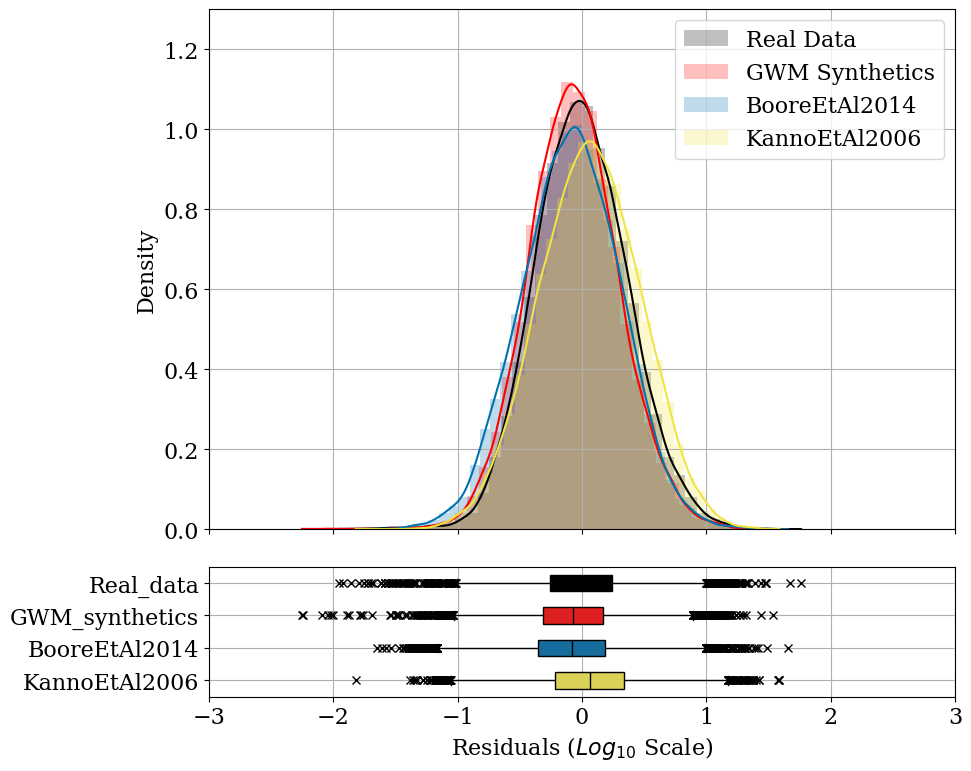

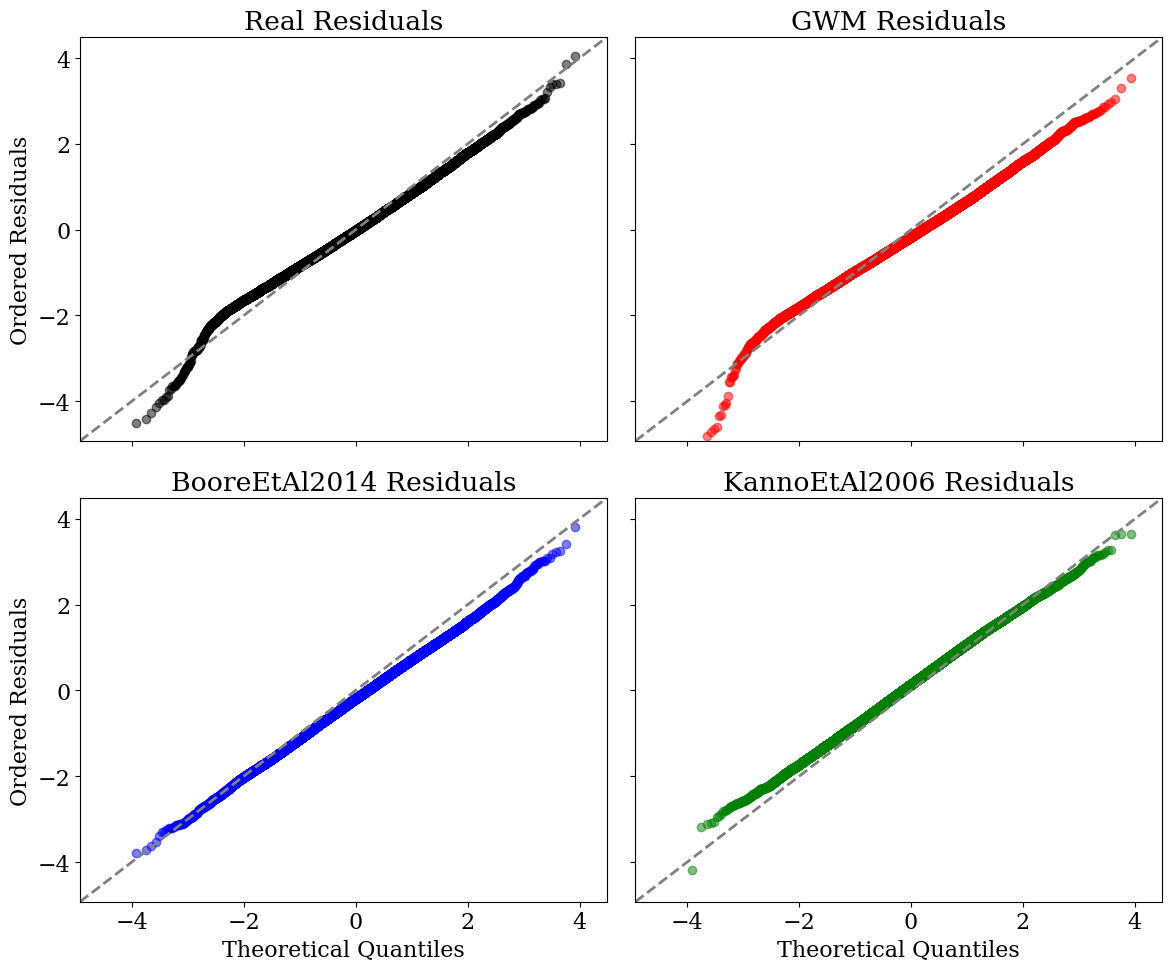

In [ ]:

# Real data
obs_data = pd.DataFrame({
    'PGV': PGV_geom_mean_obs,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# Synthetic data
synth_data = pd.DataFrame({
    'PGV': PGV_geom_mean_gm0,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# GMMs Boore data
GMM_BA_data = pd.DataFrame({
    'PGV': pgv_gmms_BA,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# GMMs Kanno data
GMM_kanno_data = pd.DataFrame({
    'PGV': pgv_gmms_kanno*10**-0.11, # correcion from how kanno calculate the average mean
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance 
})

# Combine data for model fitting
# all_data['Type'] = 'Original_data'
obs_data['Type'] = 'Real_data'
synth_data['Type'] = 'GWM_synthetics'
GMM_BA_data['Type'] = 'BooreEtAl2014'
GMM_kanno_data['Type'] = 'KannoEtAl2006'
combined_data = pd.concat([obs_data, synth_data, GMM_BA_data, GMM_kanno_data], ignore_index=True)
# all_data_com = pd.concat([all_data], ignore_index=True)

# --- 2. Transform Predictors ---

# Log-transform Vs30 and Hypocentral Distance using base-10 logarithm
combined_data['Log_Vs30'] = np.log10(combined_data['Vs30'])
combined_data['Log_Hypocentral_Distance'] = np.log10(combined_data['Hypocentral_Distance'])

# all_data_com['Log_Vs30'] = np.log10(all_data_com['Vs30'])
# all_data_com['Log_Hypocentral_Distance'] = np.log10(all_data_com['Hypocentral_Distance'])

# Log-transform PGA using base-10 logarithm
combined_data['Log_PGA'] = np.log10(combined_data['PGV'])
# all_data_com['Log_PGA'] = np.log10(all_data_com['PGV'])

# --- 3. Regression Model (GMPE) Fitted Only on Observed Data ---

# Define the predictor variables and target variable
predictors = ['Magnitude', 'Log_Vs30', 'Log_Hypocentral_Distance']
target = 'Log_PGA'

# Prepare the observed data for model fitting
obs_only_data = combined_data[combined_data['Type'] == 'Real_data']
# all_only_data = all_data_com[all_data_com['Type'] == 'Original_data']

# Design matrix (X_obs) and target variable (y_obs) for observed data
X_obs = obs_only_data[predictors]
X_obs = sm.add_constant(X_obs)  # Adds intercept term
y_obs = obs_only_data[target]

# Fit the regression model using only the observed data
model = sm.OLS(y_obs, X_obs).fit()

# Print model summary
print(model.summary())

# --- 4. Compute Predictions and Residuals for All Data ---

# Prepare the design matrix for all data (including synthetic and GMM data)
X_all = combined_data[predictors]
X_all = sm.add_constant(X_all)  # Ensure the same structure as X_obs

# Compute predicted Log_PGA for all data using the observed data model
combined_data['Predicted_Log_PGA'] = model.predict(X_all)

# Compute residuals for all data
combined_data['Residuals'] = combined_data['Log_PGA'] - combined_data['Predicted_Log_PGA']


# Compute residuals for all data
combined_data['Residuals'] = combined_data['Log_PGA'] - combined_data['Predicted_Log_PGA']

# Separate residuals for each dataset
obs_residuals = combined_data[combined_data['Type'] == 'Real_data']['Residuals']
synth_residuals = combined_data[combined_data['Type'] == 'GWM_synthetics']['Residuals']
GMMBA_residuals = combined_data[combined_data['Type'] == 'BooreEtAl2014']['Residuals']
GMMkanno_residuals = combined_data[combined_data['Type'] == 'KannoEtAl2006']['Residuals']

# --- 5. Analyze Residuals ---

# a. Descriptive Statistics
def compute_statistics(data):
    mean = np.mean(data)
    variance = np.var(data, ddof=1)
    std_dev = np.std(data, ddof=1)
    iqr = stats.iqr(data)
    return {
        'Mean': mean,
        'Variance': variance,
        'Standard Deviation': std_dev,
        'Interquartile Range': iqr
    }

obs_stats = compute_statistics(obs_residuals)
synth_stats = compute_statistics(synth_residuals)
GMMBA_stats = compute_statistics(GMMBA_residuals)
GMMkanno_stats = compute_statistics(GMMkanno_residuals)

print("\nReal Residuals Statistics:")
for key, value in obs_stats.items():
    print(f"{key}: {value:.6f}")

print("\nSynthetic Residuals Statistics:")
for key, value in synth_stats.items():
    print(f"{key}: {value:.6f}")

print("\nBooreEtAl2014 Residuals Statistics:")
for key, value in GMMBA_stats.items():
    print(f"{key}: {value:.6f}")
    
print("\nKannoEtAl2006 Residuals Statistics:")
for key, value in GMMkanno_stats.items():
    print(f"{key}: {value:.6f}")

# b. Variance Ratio
variance_ratio = obs_stats['Variance'] / synth_stats['Variance']
print(f"\nVariance Ratio (Real/Synthetic): {variance_ratio:.6f}")

variance_ratio = obs_stats['Variance'] / GMMBA_stats['Variance']
print(f"\nVariance Ratio (Real/BooreEtAl2014): {variance_ratio:.6f}")

variance_ratio = obs_stats['Variance'] / GMMkanno_stats['Variance']
print(f"\nVariance Ratio (Real/KannoEtAl2006): {variance_ratio:.6f}")

# c. Levene's Test for Equality of Variances
levene_stat, levene_p = stats.levene(obs_residuals, synth_residuals, center='mean')
print(f"\nLevene's Test Statistic: {levene_stat:.6f}")
print(f"P-value: {levene_p:.6f}")

# --- 6. Visualizations ---

# a. Histogram of Residuals
fig, (ax_hist, ax_box) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 8),
    gridspec_kw={'height_ratios': [4, 1]}  # Adjust the height ratios
)

# a. Histogram of Residuals on the top subplot
sns.histplot(
    obs_residuals,
    bins=40,
    kde=True,
    color='black',
    label='Real Data',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    synth_residuals,
    bins=40,
    kde=True,
    color='red',
    label='GWM Synthetics',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    GMMBA_residuals,
    bins=40,
    kde=True,
    color='#0072B2',
    label='BooreEtAl2014',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    GMMkanno_residuals,
    bins=40,
    kde=True,
    color='#F0E442',
    label='KannoEtAl2006',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
ax_hist.set_ylabel('Density')
ax_hist.legend()
ax_hist.grid(True)
ax_hist.set_xlim(-3, 3)  # Set x-axis limits
ax_hist.set_ylim(0, 1.3)

# b. Box Plot of Residuals on the bottom subplot
sns.boxplot(
    x='Residuals',
    y='Type',
    data=combined_data,
    orient='h',
    palette={'Real_data': 'black', 'GWM_synthetics': 'red', 'BooreEtAl2014': '#0072B2', 'KannoEtAl2006': '#F0E442'},
    width=.5,
    flierprops={"marker": "x"},
    ax=ax_box
)
ax_box.set_xlabel('Residuals ($Log_{10}$ Scale)')
ax_box.yaxis.label.set_visible(False)
ax_box.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
fig.savefig('figures/updated/histogram_stats_PGV_updated.png', dpi=300, bbox_inches='tight')
fig.savefig('figures/updated/histogram_stats_PGV_updated.svg', dpi=300, bbox_inches='tight')


# --- c. Combined Q-Q Plots of Residuals with Shared Axes and Adjusted Labels ---

# Scale factor for the transformation
scale_factor = np.log(10)

# Create a figure with 2x2 subplots and shared axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of residuals and titles
residuals_list = [
    (obs_residuals, 'Real Residuals'),
    (synth_residuals, 'GWM Residuals'),
    (GMMBA_residuals, 'BooreEtAl2014 Residuals'),
    (GMMkanno_residuals, 'KannoEtAl2006 Residuals')
]

colors = ["k", "r", "b", "g"]
# Loop over residuals and axes to create Q-Q plots
for idx, (ax, (residuals, title)) in enumerate(zip(axes, residuals_list)):
    # Apply the transformation
    transformed_residuals = residuals * scale_factor

    # Create the Q-Q plot on the specified axes
    sm.qqplot(
        transformed_residuals,
        line='45',
        ax=ax,
        alpha=0.5,
        markerfacecolor=colors[idx],
        markeredgecolor=colors[idx]
    )
    ax.get_lines()[1].set_color("gray")
    ax.get_lines()[1].set_linewidth("2")
    ax.get_lines()[1].set_linestyle("--")
    ax.set_title(title)
    
    # Remove x-axis labels on plots (1,1) and (1,2)
    if idx in [0, 1]:
        ax.set_xlabel('')  # Remove x-axis label
    else:
        ax.set_xlabel('Theoretical Quantiles')
    
    # Remove y-axis labels on plots (1,2) and (2,2)
    if idx in [1, 3]:
        ax.set_ylabel('')  # Remove y-axis label
    else:
        ax.set_ylabel('Ordered Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()
# fig.savefig('figures/qqplot_stats.png', dpi=300, bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                Log_PGA   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     3971.
Date:                Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                        00:11:02   Log-Likelihood:                -12702.
No. Observations:               22822   AIC:                         2.541e+04
Df Residuals:                   22818   BIC:                         2.544e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/tmp/ipykernel_8589/1651834263.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


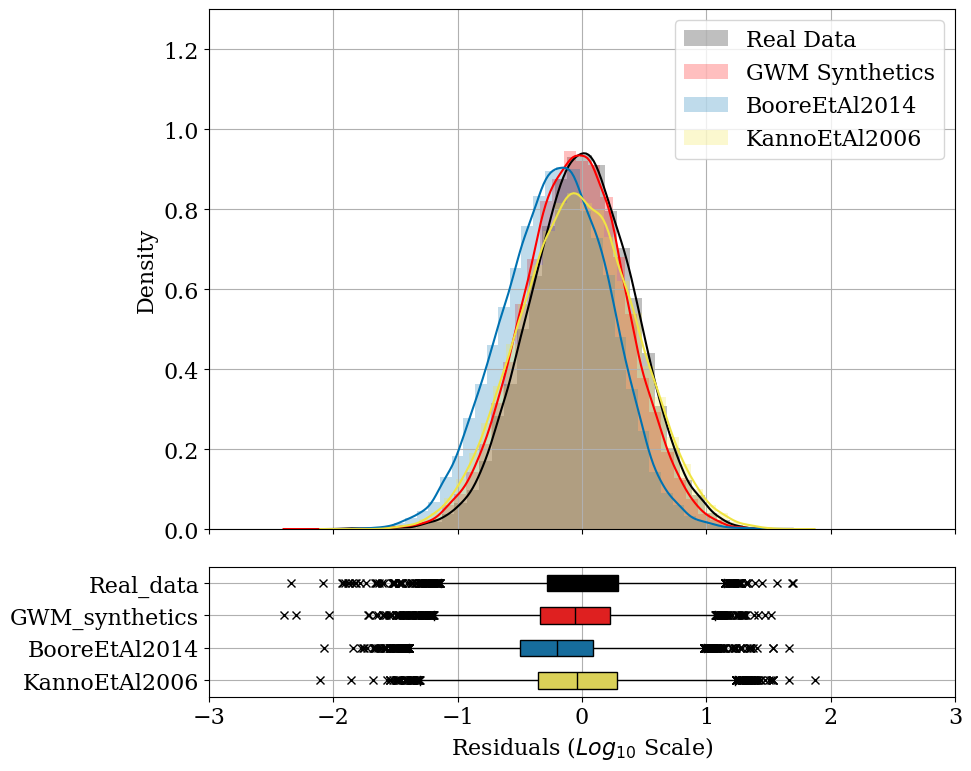

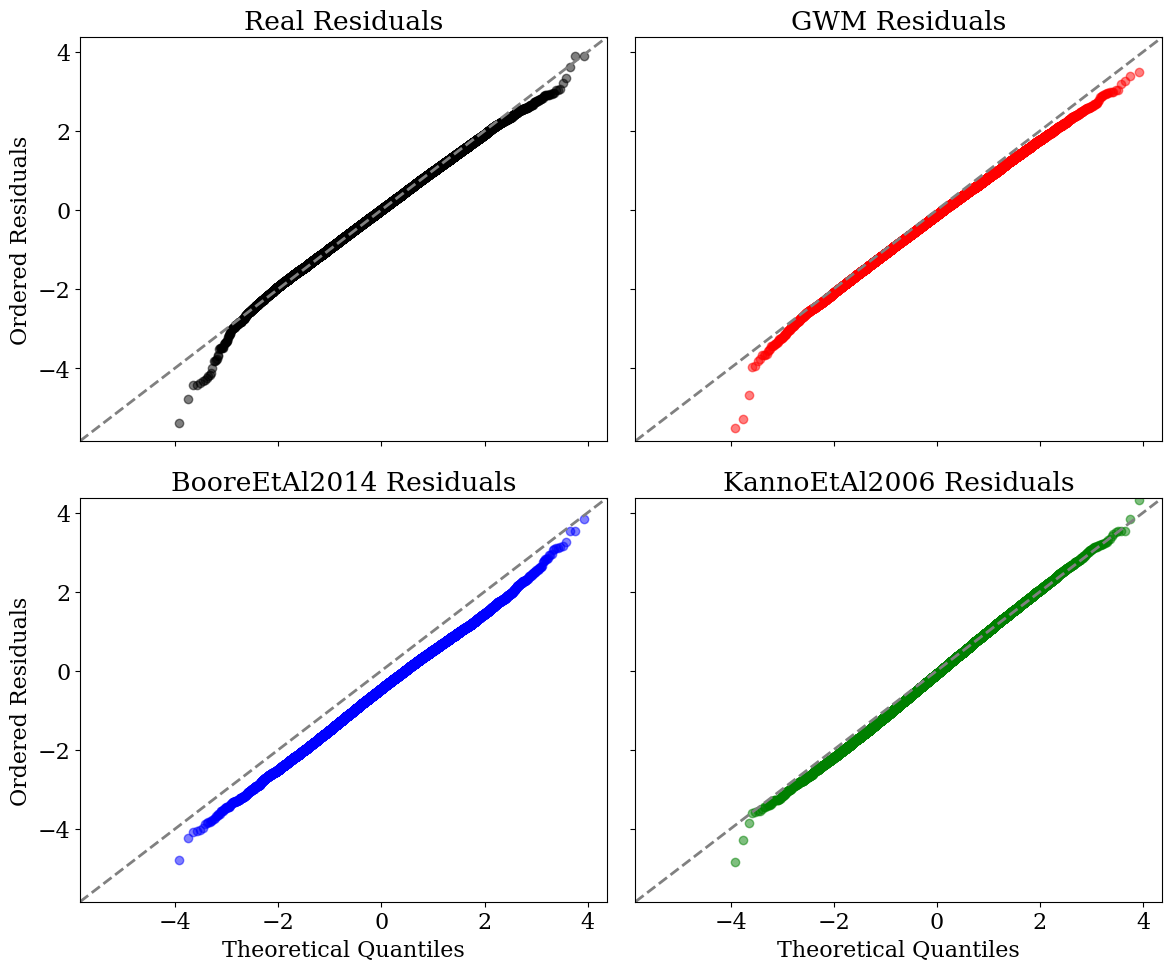

In [ ]:
# --- 1. Data Preparation ---

# Real data
obs_data = pd.DataFrame({
    'PGA': PGA_geom_mean_obs,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# Synthetic data
synth_data = pd.DataFrame({
    'PGA': PGA_geom_mean_gm0,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# GMMs Boore data
GMM_BA_data = pd.DataFrame({
    'PGA': pga_gmms_BA,
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# GMMs Kanno data
GMM_kanno_data = pd.DataFrame({
    'PGA': pga_gmms_kanno*10**-0.07, # correcion from how kanno calculate the average mean
    'Magnitude': dataset_observed.magnitude,
    'Vs30': dataset_observed.vs30s,
    'Hypocentral_Distance': dataset_observed.hypocentral_distance
})

# Combine data for model fitting
# all_data['Type'] = 'Original_data'
obs_data['Type'] = 'Real_data'
synth_data['Type'] = 'GWM_synthetics'
GMM_BA_data['Type'] = 'BooreEtAl2014'
GMM_kanno_data['Type'] = 'KannoEtAl2006'
combined_data = pd.concat([obs_data, synth_data, GMM_BA_data, GMM_kanno_data], ignore_index=True)
# all_data_com = pd.concat([all_data], ignore_index=True)

# --- 2. Transform Predictors ---

# Log-transform Vs30 and Hypocentral Distance using base-10 logarithm
combined_data['Log_Vs30'] = np.log10(combined_data['Vs30'])
combined_data['Log_Hypocentral_Distance'] = np.log10(combined_data['Hypocentral_Distance'])

# all_data_com['Log_Vs30'] = np.log10(all_data_com['Vs30'])
# all_data_com['Log_Hypocentral_Distance'] = np.log10(all_data_com['Hypocentral_Distance'])

# Log-transform PGA using base-10 logarithm
combined_data['Log_PGA'] = np.log10(combined_data['PGA'])
# all_data_com['Log_PGA'] = np.log10(all_data_com['PGA'])

# --- 3. Regression Model (GMPE) Fitted Only on Observed Data ---

# Define the predictor variables and target variable
predictors = ['Magnitude', 'Log_Vs30', 'Log_Hypocentral_Distance']
target = 'Log_PGA'

# Prepare the observed data for model fitting
obs_only_data = combined_data[combined_data['Type'] == 'Real_data']
# all_only_data = all_data_com[all_data_com['Type'] == 'Original_data']

# Design matrix (X_obs) and target variable (y_obs) for observed data
X_obs = obs_only_data[predictors]
X_obs = sm.add_constant(X_obs)  # Adds intercept term
y_obs = obs_only_data[target]

# Fit the regression model using only the observed data
model = sm.OLS(y_obs, X_obs).fit()

# Print model summary
print(model.summary())

# --- 4. Compute Predictions and Residuals for All Data ---

# Prepare the design matrix for all data (including synthetic and GMM data)
X_all = combined_data[predictors]
X_all = sm.add_constant(X_all)  # Ensure the same structure as X_obs

# Compute predicted Log_PGA for all data using the observed data model
combined_data['Predicted_Log_PGA'] = model.predict(X_all)

# Compute residuals for all data
combined_data['Residuals'] = combined_data['Log_PGA'] - combined_data['Predicted_Log_PGA']


# Compute residuals for all data
combined_data['Residuals'] = combined_data['Log_PGA'] - combined_data['Predicted_Log_PGA']

# Separate residuals for each dataset
obs_residuals = combined_data[combined_data['Type'] == 'Real_data']['Residuals']
synth_residuals = combined_data[combined_data['Type'] == 'GWM_synthetics']['Residuals']
GMMBA_residuals = combined_data[combined_data['Type'] == 'BooreEtAl2014']['Residuals']
GMMkanno_residuals = combined_data[combined_data['Type'] == 'KannoEtAl2006']['Residuals']

# --- 5. Analyze Residuals ---

# a. Descriptive Statistics
def compute_statistics(data):
    mean = np.mean(data)
    variance = np.var(data, ddof=1)
    std_dev = np.std(data, ddof=1)
    iqr = stats.iqr(data)
    return {
        'Mean': mean,
        'Variance': variance,
        'Standard Deviation': std_dev,
        'Interquartile Range': iqr
    }

obs_stats = compute_statistics(obs_residuals)
synth_stats = compute_statistics(synth_residuals)
GMMBA_stats = compute_statistics(GMMBA_residuals)
GMMkanno_stats = compute_statistics(GMMkanno_residuals)

print("\nReal Residuals Statistics:")
for key, value in obs_stats.items():
    print(f"{key}: {value:.6f}")

print("\nSynthetic Residuals Statistics:")
for key, value in synth_stats.items():
    print(f"{key}: {value:.6f}")

print("\nBooreEtAl2014 Residuals Statistics:")
for key, value in GMMBA_stats.items():
    print(f"{key}: {value:.6f}")
    
print("\nKannoEtAl2006 Residuals Statistics:")
for key, value in GMMkanno_stats.items():
    print(f"{key}: {value:.6f}")

# b. Variance Ratio
variance_ratio = obs_stats['Variance'] / synth_stats['Variance']
print(f"\nVariance Ratio (Real/Synthetic): {variance_ratio:.6f}")

variance_ratio = obs_stats['Variance'] / GMMBA_stats['Variance']
print(f"\nVariance Ratio (Real/BooreEtAl2014): {variance_ratio:.6f}")

variance_ratio = obs_stats['Variance'] / GMMkanno_stats['Variance']
print(f"\nVariance Ratio (Real/KannoEtAl2006): {variance_ratio:.6f}")

# c. Levene's Test for Equality of Variances
levene_stat, levene_p = stats.levene(obs_residuals, synth_residuals, center='mean')
print(f"\nLevene's Test Statistic: {levene_stat:.6f}")
print(f"P-value: {levene_p:.6f}")

# --- 6. Visualizations ---

# a. Histogram of Residuals
fig, (ax_hist, ax_box) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 8),
    gridspec_kw={'height_ratios': [4, 1]}  # Adjust the height ratios
)

# a. Histogram of Residuals on the top subplot
sns.histplot(
    obs_residuals,
    bins=40,
    kde=True,
    color='black',
    label='Real Data',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    synth_residuals,
    bins=40,
    kde=True,
    color='red',
    label='GWM Synthetics',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    GMMBA_residuals,
    bins=40,
    kde=True,
    color='#0072B2',
    label='BooreEtAl2014',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
sns.histplot(
    GMMkanno_residuals,
    bins=40,
    kde=True,
    color='#F0E442',
    label='KannoEtAl2006',
    stat='density',
    alpha=0.25,
    edgecolor='None',
    ax=ax_hist
)
ax_hist.set_ylabel('Density')
ax_hist.legend()
ax_hist.grid(True)
ax_hist.set_xlim(-3, 3)  # Set x-axis limits
ax_hist.set_ylim(0, 1.3)

# b. Box Plot of Residuals on the bottom subplot
sns.boxplot(
    x='Residuals',
    y='Type',
    data=combined_data,
    orient='h',
    palette={'Real_data': 'black', 'GWM_synthetics': 'red', 'BooreEtAl2014': '#0072B2', 'KannoEtAl2006': '#F0E442'},
    width=.5,
    flierprops={"marker": "x"},
    ax=ax_box
)
ax_box.set_xlabel('Residuals ($Log_{10}$ Scale)')
ax_box.yaxis.label.set_visible(False)
ax_box.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
fig.savefig('figures/updated/histogram_stats_PGA_updated.png', dpi=300, bbox_inches='tight')
fig.savefig('figures/updated/histogram_stats_PGA_updated.svg', dpi=300, bbox_inches='tight')


# --- c. Combined Q-Q Plots of Residuals with Shared Axes and Adjusted Labels ---

# Scale factor for the transformation
scale_factor = np.log(10)

# Create a figure with 2x2 subplots and shared axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of residuals and titles
residuals_list = [
    (obs_residuals, 'Real Residuals'),
    (synth_residuals, 'GWM Residuals'),
    (GMMBA_residuals, 'BooreEtAl2014 Residuals'),
    (GMMkanno_residuals, 'KannoEtAl2006 Residuals')
]

colors = ["k", "r", "b", "g"]
# Loop over residuals and axes to create Q-Q plots
for idx, (ax, (residuals, title)) in enumerate(zip(axes, residuals_list)):
    # Apply the transformation
    transformed_residuals = residuals * scale_factor

    # Create the Q-Q plot on the specified axes
    sm.qqplot(
        transformed_residuals,
        line='45',
        ax=ax,
        alpha=0.5,
        markerfacecolor=colors[idx],
        markeredgecolor=colors[idx]
    )
    ax.get_lines()[1].set_color("gray")
    ax.get_lines()[1].set_linewidth("2")
    ax.get_lines()[1].set_linestyle("--")
    ax.set_title(title)
    
    # Remove x-axis labels on plots (1,1) and (1,2)
    if idx in [0, 1]:
        ax.set_xlabel('')  # Remove x-axis label
    else:
        ax.set_xlabel('Theoretical Quantiles')
    
    # Remove y-axis labels on plots (1,2) and (2,2)
    if idx in [1, 3]:
        ax.set_ylabel('')  # Remove y-axis label
    else:
        ax.set_ylabel('Ordered Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()
# fig.savefig('figures/qqplot_stats.png', dpi=300, bbox_inches='tight')
plt.show()